In [90]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from tensorly.base import tensor_to_vec, partial_tensor_to_vec
from tensorly.datasets.synthetic import gen_image
from tensorly.regression.cp_regression import CPRegressor
from tensorly.regression.tucker_regression import TuckerRegressor
from tensorly.decomposition import parafac, tucker
from tensorly.metrics import regression
import tensorly as tl
from imodels.tree.rf_plus.rf_plus import RandomForestPlusRegressor, RandomForestPlusClassifier
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, log_loss, accuracy_score, balanced_accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
import pprint
from glmnet import ElasticNet, LogitNet
import numpy as np
import pytorch_lightning as pl
import torch
import xgboost as xgb
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
from matplotlib import pyplot as plt
from imodels.tree.rf_plus.ppms.ppms_regression import GlmNetElasticNetRegressorPPM, GlmNetRidgeRegressorPPM, GlmNetLassoRegressorPPM
from imodels.tree.rf_plus.data_transformations.block_transformers import MDIPlusDefaultTransformer, IdentityTransformer, CompositeTransformer, TreeTransformer
import tensorly as tl
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from catboost import CatBoostClassifier, CatBoostRegressor
import graphviz
from sklearn import tree
from IPython.display import Image, display
from sklearn.linear_model import LinearRegression    
import copy,imodels
from tabpfn import TabPFNClassifier


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [77]:
X, y,f = imodels.get_clean_dataset("abalone",data_source="imodels")
#y = np.array([1 if y[i] == 'positive' else 0 for i in range(len(y))])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

fetching 183 from openml


In [79]:
rf_reg = RandomForestRegressor(min_samples_leaf=5,max_features=0.33,n_estimators = 60)
rf_reg.fit(X_train, y_train)
metrics = [r2_score, mean_squared_error]
pprint.pprint(f"R2 {r2_score(y_test,rf_reg.predict(X_test))}")

'R2 0.5432871792911682'


In [87]:
import warnings
warnings.filterwarnings("ignore")
rf_plus_reg = RandomForestPlusRegressor(rf_model=rf_reg,prediction_model=GlmNetElasticNetRegressorPPM(n_alphas=50,l1_ratio=0.2,standardize=True),center=True,fit_on="all")
rf_plus_reg.fit(X_train, y_train,n_jobs=8)



In [89]:
pprint.pprint(f"R2 {r2_score(y_test,rf_plus_reg.predict(X_test))}")


'R2 0.558641692719913'


## Tensor padding 

## Tensor investigation


In [53]:
all_preds = []
all_errors = []
all_training_errors = []
for i in range(len(rf_plus_reg.transformers_)):
    transformed_flat_tensor = rf_plus_reg.transformers_[i].transform(X_train).get_all_data()
    #pprint.pprint(f"Shape of learnt matrix for tree {i} is {transformed_flat_tensor.shape}")
    test_flat_tensor = rf_plus_reg.transformers_[i].transform(X_test).get_all_data()
    ith_preds = rf_plus_reg.estimators_[i].predict(test_flat_tensor)
    all_preds.append(ith_preds)
    all_errors.append(np.abs(y_test-ith_preds))
    all_training_errors.append(np.abs(y_train-rf_plus_reg.estimators_[i].predict(transformed_flat_tensor)))
    print(f"MSE {mean_squared_error(y_test,ith_preds)}")   
    all_preds.append(rf_plus_reg.estimators_[i].predict(test_flat_tensor))
preds = np.mean(all_preds, axis=0)
#print(all_errors)

MSE 0.10720422483338962
MSE 0.12186483536975001
MSE 0.11070320190684023
MSE 0.11654588807956753
MSE 0.11699601761066675
MSE 0.10877486932215004
MSE 0.11905254548530306
MSE 0.10707133534213062
MSE 0.10986384728765068
MSE 0.11129569949813292
MSE 0.11227995114824825
MSE 0.11311582470629426
MSE 0.12235024047308864
MSE 0.11689297804997449
MSE 0.10658412220113687
MSE 0.11226504566666251
MSE 0.10865675813726824
MSE 0.1081907866357041
MSE 0.10637235904079227
MSE 0.10649351805591187
MSE 0.11200027883997303
MSE 0.10752936396545479
MSE 0.10691907158129682
MSE 0.11603752033924587
MSE 0.11364167950832758
MSE 0.11578875917189199
MSE 0.10749086200212396
MSE 0.11092353222994229
MSE 0.1071129183465349
MSE 0.1077840667196854
MSE 0.11332131869710896
MSE 0.11959386524248222
MSE 0.11183213728716625
MSE 0.10905137550537758
MSE 0.10834066160996715
MSE 0.11001722023152498
MSE 0.10919916929750242
MSE 0.11017898613841051
MSE 0.10652971088742023
MSE 0.10879560994162267
MSE 0.11300574184787643
MSE 0.1130701244745

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 [Text(0, 1, 'Row 1'),
  Text(0, 2, 'Row 2'),
  Text(0, 3, 'Row 3'),
  Text(0, 4, 'Row 4'),
  Text(0, 5, 'Row 5'),
  Text(0, 6, 'Row 6'),
  Text(0, 7, 'Row 7'),
  Text(0, 8, 'Row 8'),
  Text(0, 9, 'Row 9'),
  Text(0, 10, 'Row 10')])

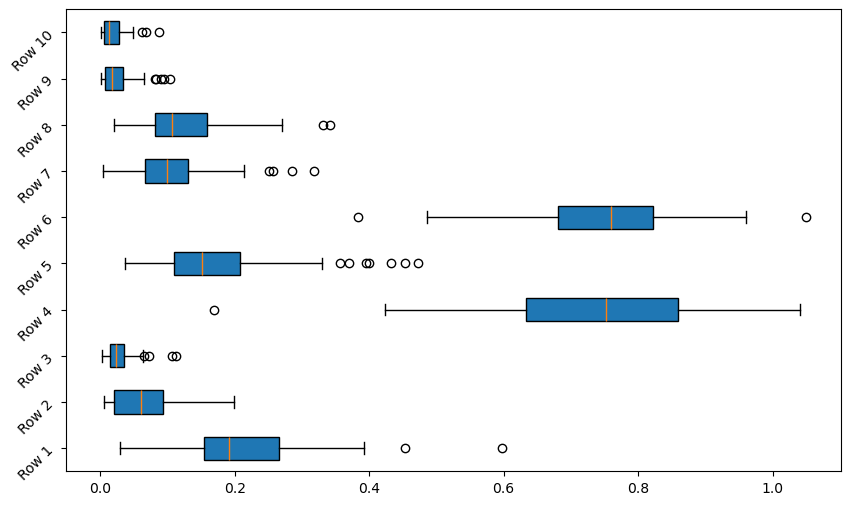

In [18]:
error_matrix = np.column_stack(all_errors)
training_error_matrix = np.column_stack(all_training_errors)
fig, ax = plt.subplots(figsize=(10, 6))

# Create box plots for the first 10 rows
box_plots = ax.boxplot(error_matrix[:10].T, vert=False, patch_artist=True)

# Set the x-axis tick labels to the row numbers
ax.set_yticks(np.arange(1, 11))
ax.set_yticklabels([f"Row {i+1}" for i in range(10)])

# Rotate the y-axis tick labels for better visibility
plt.sca(ax)
plt.yticks(rotation=45)


In [15]:
#fit tensorly model
ranks = [1]
all_tensor_preds = []
for j, rank in enumerate(ranks):
        for i in range(len(rf_plus_reg.transformers_)):
                transformed_tensor = np.transpose(rf_plus_reg.transformers_[i].transform(X_train).tensorize_all_data(),axes=(1,2,0))
                transformed_tensor = np.nan_to_num(transformed_tensor, nan=0.0)
                test_tensor = np.transpose(rf_plus_reg.transformers_[i].transform(X_test).tensorize_all_data(),axes=(1,2,0))               
                test_tensor = np.nan_to_num(test_tensor, nan=0.0)
                # Create a tensor Regressor estimator
                for reg_W in [0.1, 0.2, 0.3, 0.4, 0.5]:
                        estimator = CPRegressor(weight_rank=rank, tol=10e-7, n_iter_max=100, reg_W=0.2, verbose=0)

                # Fit the estimator to the data
                        estimator.fit(transformed_tensor, y_train)

                # Predict the data
                        y_pred = estimator.predict(test_tensor)
                        all_tensor_preds.append(y_pred)

                #get r2 score
                        r2 = r2_score(y_test, y_pred)
                        pprint.pprint(f"R2 for tree i {i} is {r2}")

                        if i > 10:
                                break

        tensor_preds = np.mean(all_tensor_preds, axis=0)
        r2 = r2_score(y_test, tensor_preds)
        pprint.pprint(f"R2 for tensorly model with rank {rank} is {r2}")

'R2 for tree i 0 is -0.09984469917591321'
'R2 for tree i 0 is -0.11468342703525747'
'R2 for tree i 0 is -0.11525885226671528'
'R2 for tree i 0 is -0.09996208355821756'
'R2 for tree i 0 is -0.10548969248936801'
'R2 for tree i 1 is -0.07946634637734107'
'R2 for tree i 1 is -0.07907430687046313'
'R2 for tree i 1 is -0.0862459409072347'
'R2 for tree i 1 is -0.07755184589047137'
'R2 for tree i 1 is -0.07703045017382837'
'R2 for tree i 2 is -0.10695021643898972'
'R2 for tree i 2 is -0.10992807228872392'


KeyboardInterrupt: 

## More Tensor Tests 

In [70]:
X_train_tree_tensor = np.transpose(rf_plus_reg.tensorize(X_train, by = "tree"), axes=(0,2,1))
X_test_tree_tensor = np.transpose(rf_plus_reg.tensorize(X_test, by = "tree"), axes=(0,2,1))
X_train_tensor_impute = np.nan_to_num(X_train_tree_tensor, nan=0.0)
X_test_tree_tensor_impute = np.nan_to_num(X_test_tree_tensor, nan=0.0)


# Tucker and CP Regression

In [76]:
ranks = [1,2,3,4,5]
reg_Ws = [0.01,0.05,0.1, 0.2, 0.3, 0.4, 0.5]
for reg_W in reg_Ws:
    estimator = CPRegressor(weight_rank= ranks[0], tol=10e-7, n_iter_max=100, reg_W=reg_W, verbose=1)
    estimator.fit(X_train_tensor_impute, y_train)
    print(f"MSE for Tucker model with rank {rank} and reg_W {reg_W} is {mean_squared_error(y_test, estimator.predict(X_test_tree_tensor_impute))}")

MSE for Tucker model with rank 3 and reg_W 0.01 is 0.15466285611525776
MSE for Tucker model with rank 3 and reg_W 0.05 is 0.15372929341785307
MSE for Tucker model with rank 3 and reg_W 0.1 is 0.15382541213060513
MSE for Tucker model with rank 3 and reg_W 0.2 is 0.15484918289201652


KeyboardInterrupt: 

In [71]:
ranks = [1, 2, 3, 4, 5]
for rank in ranks:
    estimator = TuckerRegressor(weight_ranks=[rank,rank], tol=10e-7, n_iter_max=100, reg_W=1, verbose=0)
    estimator.fit(X_train_tensor_impute, y_train)
    print(f"MSE for Tucker model with rank {rank} is {mean_squared_error(y_test, estimator.predict(X_test_tree_tensor_impute))}")

MSE for Tucker model with rank 1 is 0.15403731169378534


KeyboardInterrupt: 